In [1]:
import os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

recipes_2 = nx.read_gml("recipe_graph_2_common_ingredients.gml")
recipes_5 = nx.read_gml("recipe_graph_5_common_ingredients.gml")

## Do recipes from the same cuisine form distinct communities within the graph?


In [6]:
def randomize_graph(graph):
    randomized_graph = nx.algorithms.smallworld.random_reference(graph, connectivity=False)
    return randomized_graph

In [7]:
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities, modularity

def print_total_communities_and_modularity(G, method, communities):
    total_communities = len(communities)
    modularity_value = modularity(G, communities)
    print(f"{method} - Total Communities: {total_communities}, Modularity: {modularity_value:.4f}")

def communities_greedy_label_summary(G, dataset_name):
    greedy_communities = list(greedy_modularity_communities(G))
    print_total_communities_and_modularity(G, "Greedy Modularity", greedy_communities)

    label_communities = list(label_propagation_communities(G))
    print_total_communities_and_modularity(G, "Label Propagation", label_communities)

print("\n=== Greedy and Label ===")
communities_greedy_label_summary(recipes_2, 'Graph 2 Common Ingredients')

print("\n=== Randomized ===")
recipes_2_randomized = randomize_graph(recipes_2)
communities_greedy_label_summary(recipes_2_randomized, 'Graph 2 Common Ingredients Randomized')


=== Greedy and Label ===
Greedy Modularity - Total Communities: 51, Modularity: 0.2571
Label Propagation - Total Communities: 49, Modularity: 0.0008

=== Randomized ===
Greedy Modularity - Total Communities: 49, Modularity: 0.0648
Label Propagation - Total Communities: 45, Modularity: 0.0000


In [9]:

def print_communities_by_name(G, method, communities):
    print(f"\n{method}:")
    for i, community in enumerate(communities):
        node_names = [G.nodes[node]['name'] for node in community]
        print(f"\nCommunity {i+1} ({len(node_names)} recipes):")
        for idx, name in enumerate(node_names, start=1):
            print(f"  {idx}. {name}")
    print(f"\nTotal number of communities: {len(communities)}")
    print(f"Modularity: {modularity(G, communities):.4f}")

def communities_greedy_label(G, dataset_name):
    greedy_communities = list(greedy_modularity_communities(G))
    print_communities_by_name(G, "Greedy Modularity", greedy_communities)

    label_communities = list(label_propagation_communities(G))
    print_communities_by_name(G, "Label Propagation", label_communities)



In [10]:
communities_greedy_label(recipes_2, 'Graph 2 Common Ingredients')


Greedy Modularity:

Community 1 (247 recipes):
  1. ant  kelly s london broil marinade
  2. loco moco  style hamburger steak with gravy
  3. chile rellenos
  4. drunken  pork chops
  5. red  macaroni salad
  6. one pot   dinner
  7. nat s king cole  coleslaw
  8. creamed  spinach
  9. quick biscuit bread
  10. goulashy  beef stew for the slow cooker
  11. healthy  fried rice
  12. creamy  mushroom soup
  13. 20 000 prize winning chili con carne
  14. pizza  stuffed potato
  15. cream  of cauliflower soup  vegan
  16. pour over anything  mushroom gravy
  17. secret ingredient  bbq meatloaf
  18. pass me another   hot clam dip
  19. crabby  cracker spread
  20. cheesy  tuna casserole
  21. mom s chicken
  22. near east  rice pilaf  low fat
  23. just trust me  bistro chicken salad
  24. better than a can  homemade sloppy joes
  25. 5 minute bread  pizza
  26. chic  greek salad
  27. the mooch     zucchini sandwich
  28. any type  nut butter
  29. sausage  and gravy  low fat
  30. not yo

In [11]:
communities_greedy_label(recipes_5, 'Graph 5 Common Ingredients')


Greedy Modularity:

Community 1 (34 recipes):
  1. good morning   muffins
  2. rise and shine  german fruit pancake
  3. it still feels like winter  vegan oatmeal muffins
  4. quick buns
  5. spicy  banana bread
  6. splenda   d  cheesecake sugar free low carb
  7. atkins friendly  cheesecake
  8. 100 chocolate cake
  9. wacky cake
  10. we hate zucchini bread   zucchini bread
  11. add in anything  muffins
  12. amerikaner   german vanilla biscuit
  13. tastes like mounds bar    kahlua cake
  14. oh i love this   cheesecake
  15. mom s amazing banana bread
  16. just peachy  cobbler
  17. keep it going  german friendship cake
  18. rich  hot fudge cake
  19. the best  banana bread  or muffins
  20. mohnstrietzel   german poppy seed cake
  21. 250 chocolate chip cookies recipe
  22. chmeur s  pudding
  23. fabulous  brownies
  24. missy s  sweet potato casserole
  25. beat this  banana bread
  26. you can t eat just one  ice box cookies
  27. puddingkuchen   custard bake
  28. 250 00 

## Which ingredients act as ”bridges” between different cuisines?

In [12]:
from collections import Counter
import numpy as np


def analyze_communities(G, communities):
    analysis_results = []

    for i, community in enumerate(communities):
        recipe_names = [G.nodes[node]['name'] for node in community]

        all_ingredients = []
        for node in community:
            all_ingredients.extend(G.nodes[node].get('ingredients', []))

        ingredient_counts = Counter(all_ingredients)
        most_common_ingredients = ingredient_counts.most_common(10)  # Top 10 ingredients

        avg_num_ingredients = np.mean([G.nodes[node]['num_ingredients'] for node in community])

        # Store the analysis results
        analysis_results.append({
            "community": i + 1,
            "num_recipes": len(community),
            "most_common_ingredients": most_common_ingredients,
            "avg_num_ingredients": avg_num_ingredients,
            "recipe_names": recipe_names
        })

    return analysis_results


def print_community_analysis(results):
    for result in results:
        print("=" * 50)
        print(f"Community {result['community']}")
        print(f"Number of Recipes: {result['num_recipes']}")
        print(f"Average Number of Ingredients: {result['avg_num_ingredients']:.2f}")
        print("\nMost Common Ingredients:")
        for ingredient, count in result['most_common_ingredients']:
            print(f"  - {ingredient} ({count} times)")

        print("\nFirst 20 Recipes:")
        for idx, name in enumerate(result['recipe_names'][:20], start=1):
            print(f"  {idx}. {name}")
        print("=" * 50)



In [17]:
def find_bridge_ingredients(G, communities):
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i

    bridge_ingredients = []
    for u, v in G.edges():
        if node_to_community[u] != node_to_community[v]:
            ingredients_u = set(G.nodes[u].get('ingredients', []))
            ingredients_v = set(G.nodes[v].get('ingredients', []))
            common_ingredients = ingredients_u.intersection(ingredients_v)
            bridge_ingredients.extend(common_ingredients)

    ingredient_counts = Counter(bridge_ingredients)

    return ingredient_counts

In [18]:
from collections import defaultdict

def find_bridge_ingredients_with_details(G, communities):
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i + 1  

    bridge_ingredient_details = defaultdict(list)

    for u, v in G.edges():
        community_u = node_to_community[u]
        community_v = node_to_community[v]
        if community_u != community_v:
            ingredients_u = set(G.nodes[u].get('ingredients', []))
            ingredients_v = set(G.nodes[v].get('ingredients', []))
            common_ingredients = ingredients_u.intersection(ingredients_v)
            for ingredient in common_ingredients:
                bridge_ingredient_details[ingredient].append({
                    "recipe_u": G.nodes[u]['name'],
                    "community_u": community_u,
                    "recipe_v": G.nodes[v]['name'],
                    "community_v": community_v
                })

    return bridge_ingredient_details


### Graph_2

In [21]:
greedy_communities = list(greedy_modularity_communities(recipes_2))
community_analysis_results = analyze_communities(recipes_2, greedy_communities)
print_community_analysis(community_analysis_results)

Community 1
Number of Recipes: 247
Average Number of Ingredients: 10.29

Most Common Ingredients:
  - salt (95 times)
  - onion (84 times)
  - pepper (51 times)
  - olive oil (45 times)
  - garlic cloves (39 times)
  - water (36 times)
  - garlic powder (35 times)
  - butter (29 times)
  - garlic (25 times)
  - black pepper (25 times)

First 20 Recipes:
  1. ant  kelly s london broil marinade
  2. loco moco  style hamburger steak with gravy
  3. chile rellenos
  4. drunken  pork chops
  5. red  macaroni salad
  6. one pot   dinner
  7. nat s king cole  coleslaw
  8. creamed  spinach
  9. quick biscuit bread
  10. goulashy  beef stew for the slow cooker
  11. healthy  fried rice
  12. creamy  mushroom soup
  13. 20 000 prize winning chili con carne
  14. pizza  stuffed potato
  15. cream  of cauliflower soup  vegan
  16. pour over anything  mushroom gravy
  17. secret ingredient  bbq meatloaf
  18. pass me another   hot clam dip
  19. crabby  cracker spread
  20. cheesy  tuna casserole


In [22]:
bridge_ingredient_counts = find_bridge_ingredients(recipes_2, greedy_communities)

print(f"{'Rank':<5} {'Ingredient':<25} {'Number of Connections'}")
print("=" * 50)
for rank, (ingredient, count) in enumerate(bridge_ingredient_counts.most_common(), start=1):
    print(f"{rank:<5} {ingredient:<25} {count}")

Rank  Ingredient                Number of Connections
1     salt                      2437
2     butter                    869
3     water                     561
4     flour                     491
5     milk                      487
6     sugar                     466
7     eggs                      370
8     pepper                    312
9     brown sugar               206
10    onion                     140
11    egg                       138
12    all-purpose flour         120
13    vegetable oil             116
14    lemon juice               86
15    sour cream                71
16    salt and pepper           69
17    cinnamon                  65
18    oil                       64
19    onions                    62
20    cheddar cheese            58
21    parmesan cheese           58
22    cream cheese              47
23    garlic cloves             46
24    celery                    42
25    paprika                   37
26    baking powder             37
27    olive oil       

In [24]:
bridge_ingredient_details = find_bridge_ingredients_with_details(recipes_2, greedy_communities)

# Display up to 10 detailed connections for each bridge ingredient
print("=" * 120)
print(f"{'Ingredient':<20} {'Recipe 1 (Community)':<45} {'Recipe 2 (Community)':<45}")
print("=" * 120)

for ingredient, connections in bridge_ingredient_details.items():
    print(f"\nIngredient: {ingredient}")
    for connection in connections[:10]:  # Limit to 10 recipe pairs per ingredient
        print(f"  - {connection['recipe_u']} (Community {connection['community_u']}) "
              f"<-> {connection['recipe_v']} (Community {connection['community_v']})")
    print("-" * 120)

Ingredient           Recipe 1 (Community)                          Recipe 2 (Community)                         

Ingredient: salt
  - arriba   baked winter squash mexican style (Community 10) <-> alouette  potatoes (Community 12)
  - arriba   baked winter squash mexican style (Community 10) <-> backyard style  barbecued ribs (Community 16)
  - arriba   baked winter squash mexican style (Community 10) <-> cream  of spinach soup  vegan (Community 28)
  - arriba   baked winter squash mexican style (Community 10) <-> deep fried dessert thingys (Community 2)
  - arriba   baked winter squash mexican style (Community 10) <-> easiest ever  hollandaise sauce (Community 29)
  - arriba   baked winter squash mexican style (Community 10) <-> get the sensation  brownies (Community 3)
  - arriba   baked winter squash mexican style (Community 10) <-> i yam what i yam two  muffins (Community 3)
  - arriba   baked winter squash mexican style (Community 10) <-> jeanne s style  birthday cake (Community 3

### Graph_5

In [25]:
greedy_communities = list(greedy_modularity_communities(recipes_5))
community_analysis_results = analyze_communities(recipes_5, greedy_communities)
print_community_analysis(community_analysis_results)

Community 1
Number of Recipes: 34
Average Number of Ingredients: 10.82

Most Common Ingredients:
  - flour (29 times)
  - eggs (26 times)
  - sugar (25 times)
  - vanilla (24 times)
  - salt (22 times)
  - butter (19 times)
  - baking soda (16 times)
  - milk (13 times)
  - baking powder (13 times)
  - cinnamon (12 times)

First 20 Recipes:
  1. good morning   muffins
  2. rise and shine  german fruit pancake
  3. it still feels like winter  vegan oatmeal muffins
  4. quick buns
  5. spicy  banana bread
  6. splenda   d  cheesecake sugar free low carb
  7. atkins friendly  cheesecake
  8. 100 chocolate cake
  9. wacky cake
  10. we hate zucchini bread   zucchini bread
  11. add in anything  muffins
  12. amerikaner   german vanilla biscuit
  13. tastes like mounds bar    kahlua cake
  14. oh i love this   cheesecake
  15. mom s amazing banana bread
  16. just peachy  cobbler
  17. keep it going  german friendship cake
  18. rich  hot fudge cake
  19. the best  banana bread  or muffins


In [26]:
bridge_ingredient_counts = find_bridge_ingredients(recipes_5, greedy_communities)

print(f"{'Rank':<5} {'Ingredient':<25} {'Number of Connections'}")
print("=" * 50)
for rank, (ingredient, count) in enumerate(bridge_ingredient_counts.most_common(), start=1):
    print(f"{rank:<5} {ingredient:<25} {count}")

Rank  Ingredient                Number of Connections
1     salt                      182
2     eggs                      126
3     baking powder             121
4     butter                    111
5     sugar                     108
6     flour                     88
7     baking soda               80
8     vanilla                   79
9     milk                      52
10    brown sugar               39
11    cinnamon                  33
12    egg                       15
13    water                     14
14    raisins                   11
15    all-purpose flour         10
16    vegetable oil             9
17    powdered sugar            8
18    cream cheese              8
19    nuts                      7
20    oil                       6
21    nutmeg                    5
22    granulated sugar          4
23    chocolate chips           4
24    ground cinnamon           3
25    ground cloves             3
26    carrots                   3
27    white sugar               3
28    so

In [27]:
bridge_ingredient_details = find_bridge_ingredients_with_details(recipes_2, greedy_communities)

# Display up to 10 detailed connections for each bridge ingredient
print("=" * 120)
print(f"{'Ingredient':<20} {'Recipe 1 (Community)':<45} {'Recipe 2 (Community)':<45}")
print("=" * 120)

for ingredient, connections in bridge_ingredient_details.items():
    print(f"\nIngredient: {ingredient}")
    for connection in connections[:10]:  # Limit to 10 recipe pairs per ingredient
        print(f"  - {connection['recipe_u']} (Community {connection['community_u']}) "
              f"<-> {connection['recipe_v']} (Community {connection['community_v']})")
    print("-" * 120)

Ingredient           Recipe 1 (Community)                          Recipe 2 (Community)                         

Ingredient: salt
  - arriba   baked winter squash mexican style (Community 10) <-> alouette  potatoes (Community 12)
  - arriba   baked winter squash mexican style (Community 10) <-> backyard style  barbecued ribs (Community 16)
  - arriba   baked winter squash mexican style (Community 10) <-> cream  of spinach soup  vegan (Community 28)
  - arriba   baked winter squash mexican style (Community 10) <-> deep fried dessert thingys (Community 2)
  - arriba   baked winter squash mexican style (Community 10) <-> easiest ever  hollandaise sauce (Community 29)
  - arriba   baked winter squash mexican style (Community 10) <-> get the sensation  brownies (Community 3)
  - arriba   baked winter squash mexican style (Community 10) <-> i yam what i yam two  muffins (Community 3)
  - arriba   baked winter squash mexican style (Community 10) <-> jeanne s style  birthday cake (Community 3

## What are the most versatile or influential recipes based on their graph connectivity?

In [20]:
def compute_centralities(graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph)
    
    return {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality,
        'closeness': closeness_centrality,
        'eigenvector': eigenvector_centrality
    }

def get_top_recipes(graph, centralities, centrality_type='degree', top_n=10):
    if centrality_type not in centralities:
        raise ValueError("Invalid centrality type. Choose from ['degree', 'betweenness', 'closeness', 'eigenvector']")
    
    sorted_centralities = sorted(centralities[centrality_type].items(), key=lambda x: x[1], reverse=True)
    sorted_centralities = [(graph.nodes[node]['name'], centrality) for node, centrality in sorted_centralities]
    return sorted_centralities[:top_n] 


from collections import Counter

def get_top_recipes_by_frequency(graph, centralities, top_n=5):
    all_top_recipes = []
    
    for centrality_type in ['degree', 'betweenness', 'closeness', 'eigenvector']:
        top_recipes = get_top_recipes(graph, centralities, centrality_type=centrality_type, top_n=top_n)
        all_top_recipes.extend([recipe[0] for recipe in top_recipes]) 
    
    recipe_counts = Counter(all_top_recipes)
    
    top_recipes_by_frequency = recipe_counts.most_common(top_n)
    
    return top_recipes_by_frequency



In [21]:
def centralities_info(graph, graph_name):
    
    centralities = compute_centralities(graph)
    print(f"Centralities for {graph_name}: {centralities}")

    top_recipes_by_frequency = get_top_recipes_by_frequency(graph, centralities, top_n=5)
    print(f"Top Recipes by Frequency across Centralities in {graph_name}:")
    for recipe, count in top_recipes_by_frequency:
        print(f"{recipe}: {count} times")
    

In [22]:
centralities_info(recipes_2, "Recipe network with min. 2 common ingredients")

Centralities for Recipe network with min. 2 common ingredients: {'degree': {'137739': 0.13827655310621242, '31490': 0.06412825651302605, '112140': 0.1503006012024048, '59389': 0.14629258517034066, '44061': 0.18837675350701402, '5289': 0.002004008016032064, '25274': 0.01002004008016032, '67888': 0.22044088176352702, '70971': 0.002004008016032064, '75452': 0.1903807615230461, '109439': 0.0, '42198': 0.09819639278557113, '67547': 0.2545090180360721, '107517': 0.05611222444889779, '39959': 0.0, '63986': 0.1442885771543086, '43026': 0.0060120240480961915, '23933': 0.0, '8559': 0.05410821643286573, '23850': 0.1062124248496994, '76808': 0.10821643286573146, '24701': 0.16633266533066132, '83873': 0.0721442885771543, '107699': 0.30260521042084165, '49262': 0.11222444889779558, '48156': 0.0060120240480961915, '54272': 0.17434869739478956, '47366': 0.19639278557114226, '37073': 0.0, '44123': 0.1222444889779559, '27087': 0.2685370741482966, '59952': 0.19639278557114226, '93249': 0.0040080160320641

In [23]:
centralities_info(recipes_5, "Recipe network with min. 5 common ingredients")

Centralities for Recipe network with min. 5 common ingredients: {'degree': {'137739': 0.0, '31490': 0.0, '112140': 0.002004008016032064, '59389': 0.0, '44061': 0.0, '5289': 0.0, '25274': 0.0, '67888': 0.0, '70971': 0.0, '75452': 0.0060120240480961915, '109439': 0.0, '42198': 0.0, '67547': 0.004008016032064128, '107517': 0.0, '39959': 0.0, '63986': 0.0, '43026': 0.0, '23933': 0.0, '8559': 0.0, '23850': 0.0, '76808': 0.0, '24701': 0.0, '83873': 0.002004008016032064, '107699': 0.03206412825651302, '49262': 0.0, '48156': 0.0, '54272': 0.004008016032064128, '47366': 0.002004008016032064, '37073': 0.0, '44123': 0.002004008016032064, '27087': 0.038076152304609215, '59952': 0.002004008016032064, '93249': 0.0, '54100': 0.0, '67664': 0.0, '87098': 0.0, '25775': 0.0, '33165': 0.0, '38798': 0.0, '22123': 0.0, '90921': 0.0, '93959': 0.08617234468937875, '93958': 0.022044088176352703, '58224': 0.0, '33606': 0.0, '94710': 0.0, '35173': 0.0, '83025': 0.05410821643286573, '52804': 0.002004008016032064,

In [24]:
def plot_centrality_distributions(df, graph_name):
    centrality_types = ['degree', 'closeness', 'betweenness', 'eigenvector']
    titles = [
        'Degree Centrality',
        'Closeness Centrality',
        'Betweenness Centrality',
        'Eigenvector Centrality'
    ]

    # Create subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    for ax, centrality_type, title in zip(axes, centrality_types, titles):
        ax.hist(df[centrality_type], bins=30, edgecolor='black')
        ax.set_title(f'Distribution of {title}')
        ax.set_xlabel(f'{title} Value')
        ax.set_ylabel('Frequency')

    plt.suptitle(f'Distribution of Centralities for {graph_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()
    


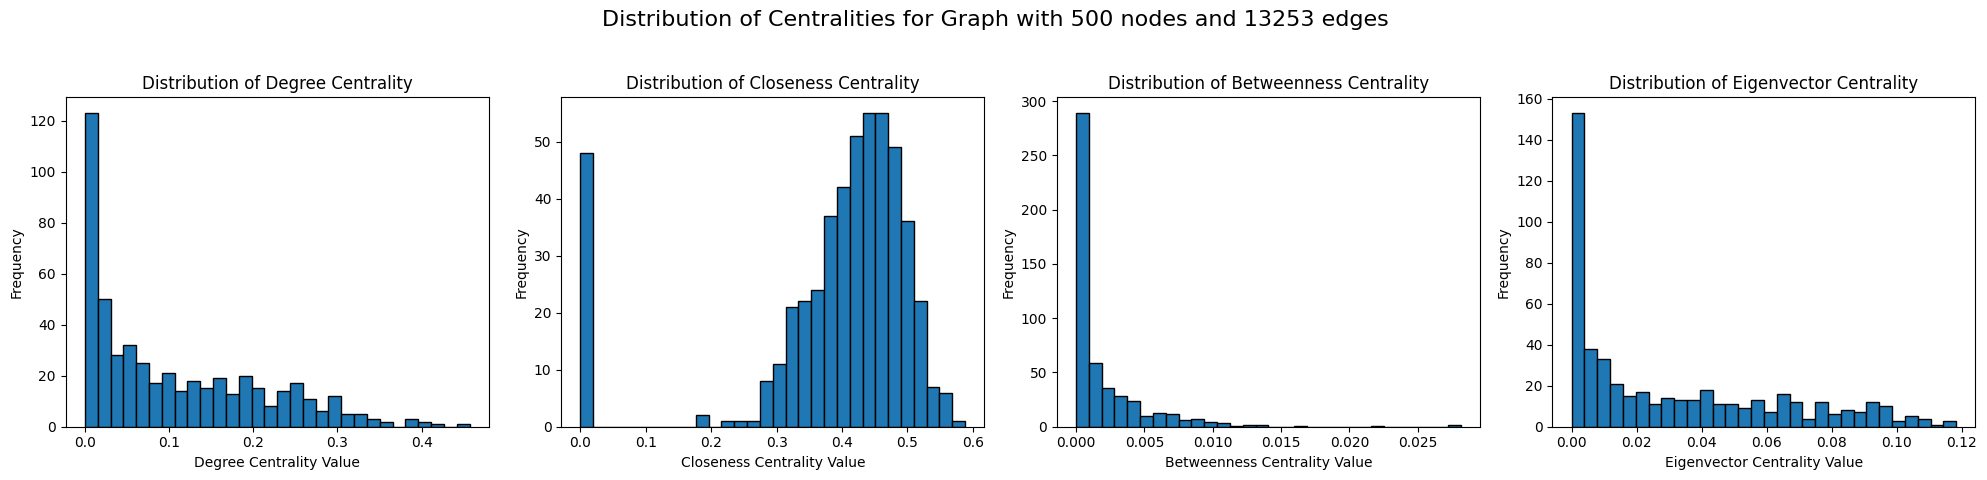

In [25]:
centralities = compute_centralities(recipes_2)
df = pd.DataFrame(centralities)
plot_centrality_distributions(df, recipes_2)

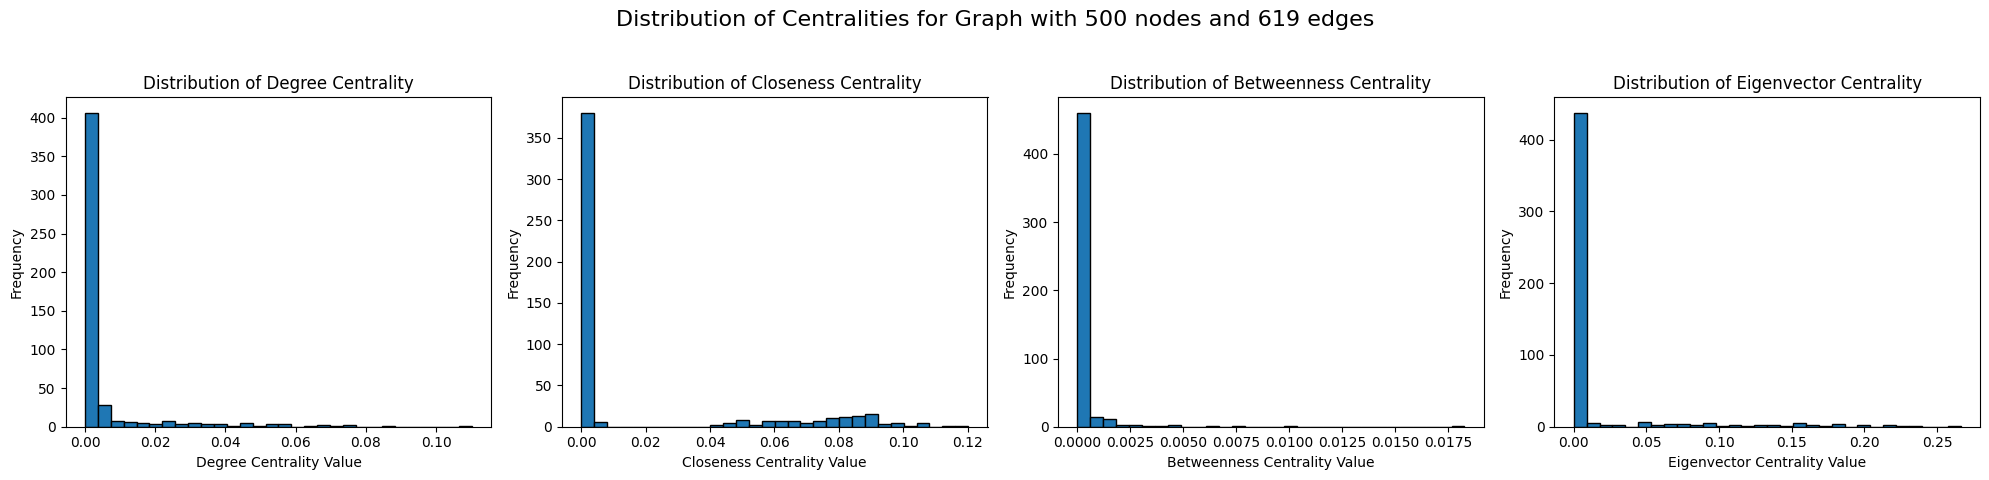

In [26]:
centralities = compute_centralities(recipes_5)
df = pd.DataFrame(centralities)
plot_centrality_distributions(df, recipes_5)

## Extra calculations

In [27]:
from scipy.stats import pearsonr, spearmanr, kendalltau


def compute_correlation(df, col1, col2):
    pearson_corr, _ = pearsonr(df[col1], df[col2])
    spearman_corr, _ = spearmanr(df[col1], df[col2])
    kendall_corr, _ = kendalltau(df[col1], df[col2])
    return pearson_corr, spearman_corr, kendall_corr

def plot_centrality_scatter_plots(df, graph_name):
    centrality_columns = [
        'degree',
        'closeness',
        'betweenness',
        'eigenvector'
    ]
    
    # We created a grid for the scatter plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()  
    
    plot_index = 0
    for i in range(len(centrality_columns)):
        for j in range(i + 1, len(centrality_columns)):
            col1 = centrality_columns[i]
            col2 = centrality_columns[j]
            
            # Compute correlations
            pearson_corr, spearman_corr, kendall_corr = compute_correlation(df, col1, col2)
            
            # Scatter plot using matplotlib
            axes[plot_index].scatter(df[col1], df[col2], alpha=0.7)
            axes[plot_index].set_title(f'Scatter Plot: {col1} vs {col2}')
            axes[plot_index].set_xlabel(col1)
            axes[plot_index].set_ylabel(col2)
            
            # Annotate correlation coefficients
            axes[plot_index].text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}\nKendall: {kendall_corr:.2f}', 
                                   transform=axes[plot_index].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
            
            plot_index += 1

    plt.tight_layout()
    plt.suptitle(f'Centrality Correlations for {graph_name}', fontsize=16, y=1.02)
    plt.show()


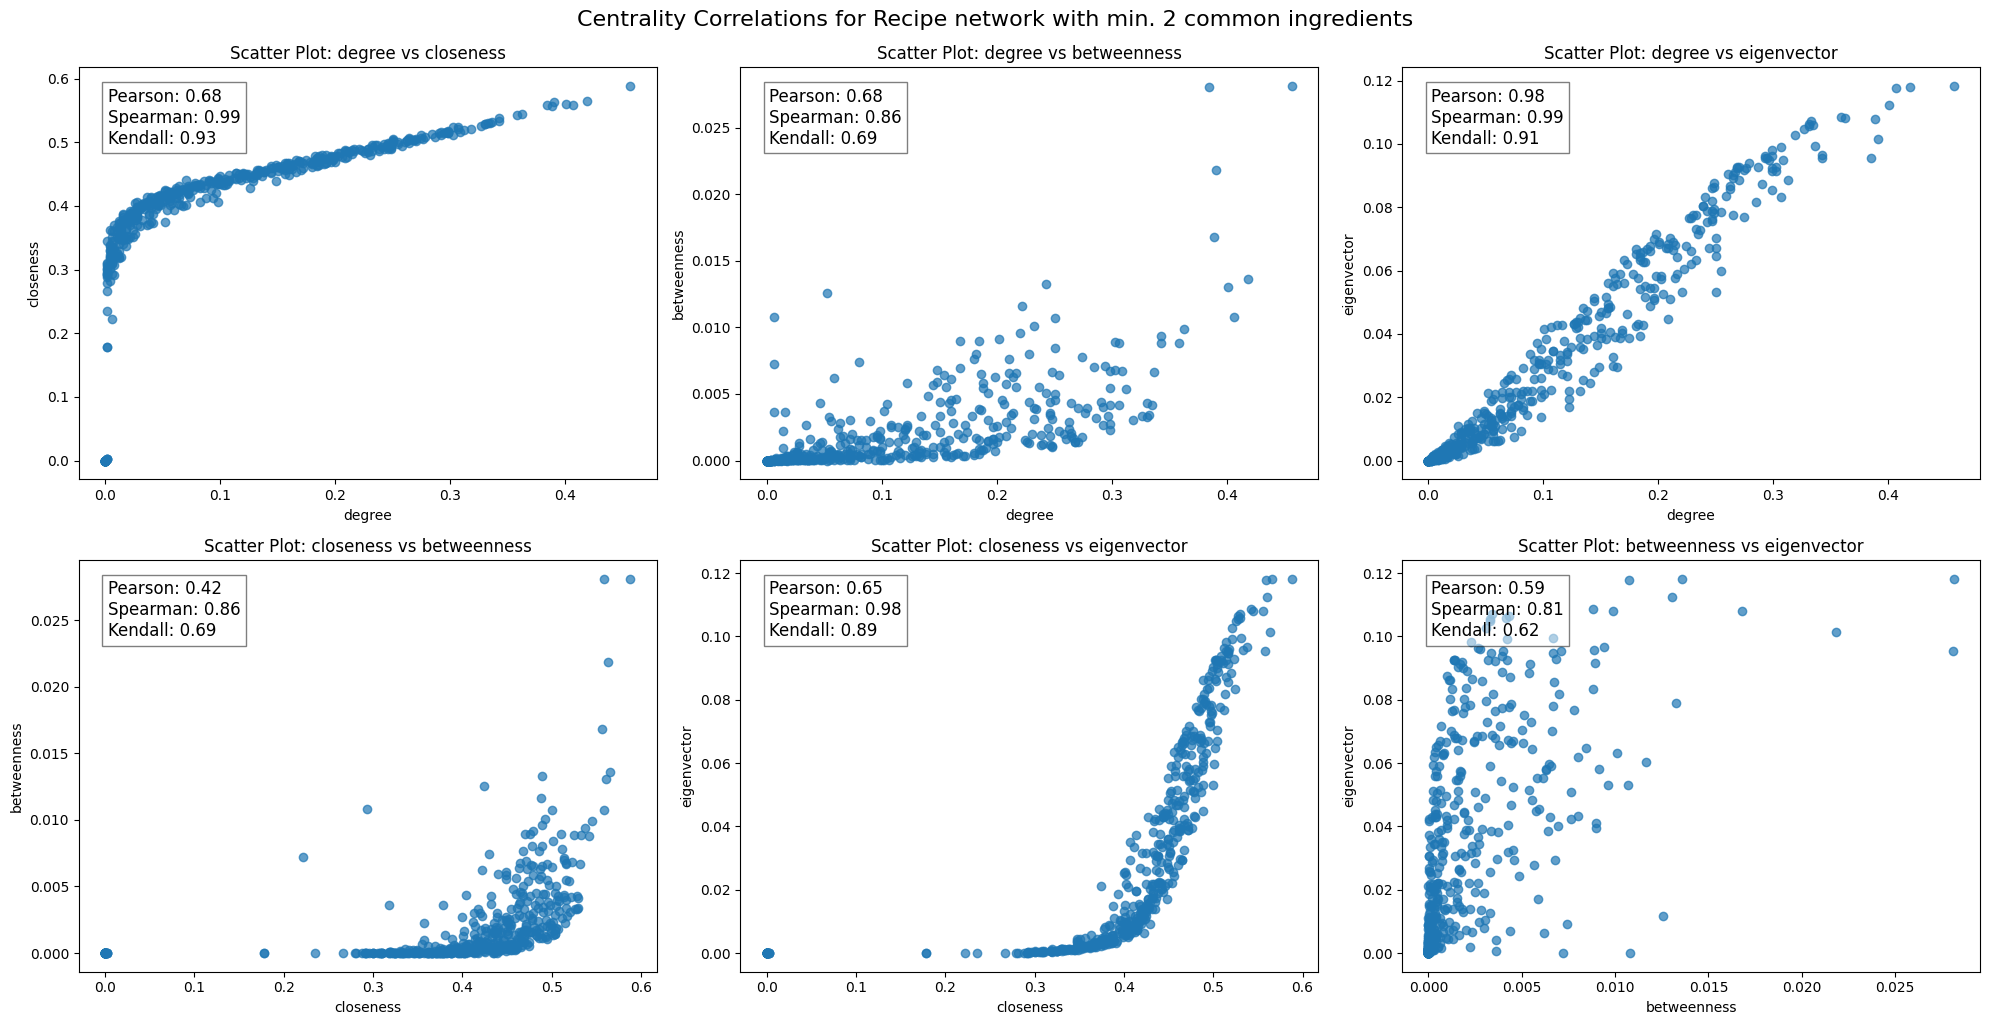

In [28]:
centralities = compute_centralities(recipes_2)
df = pd.DataFrame(centralities)
plot_centrality_scatter_plots(df, "Recipe network with min. 2 common ingredients")

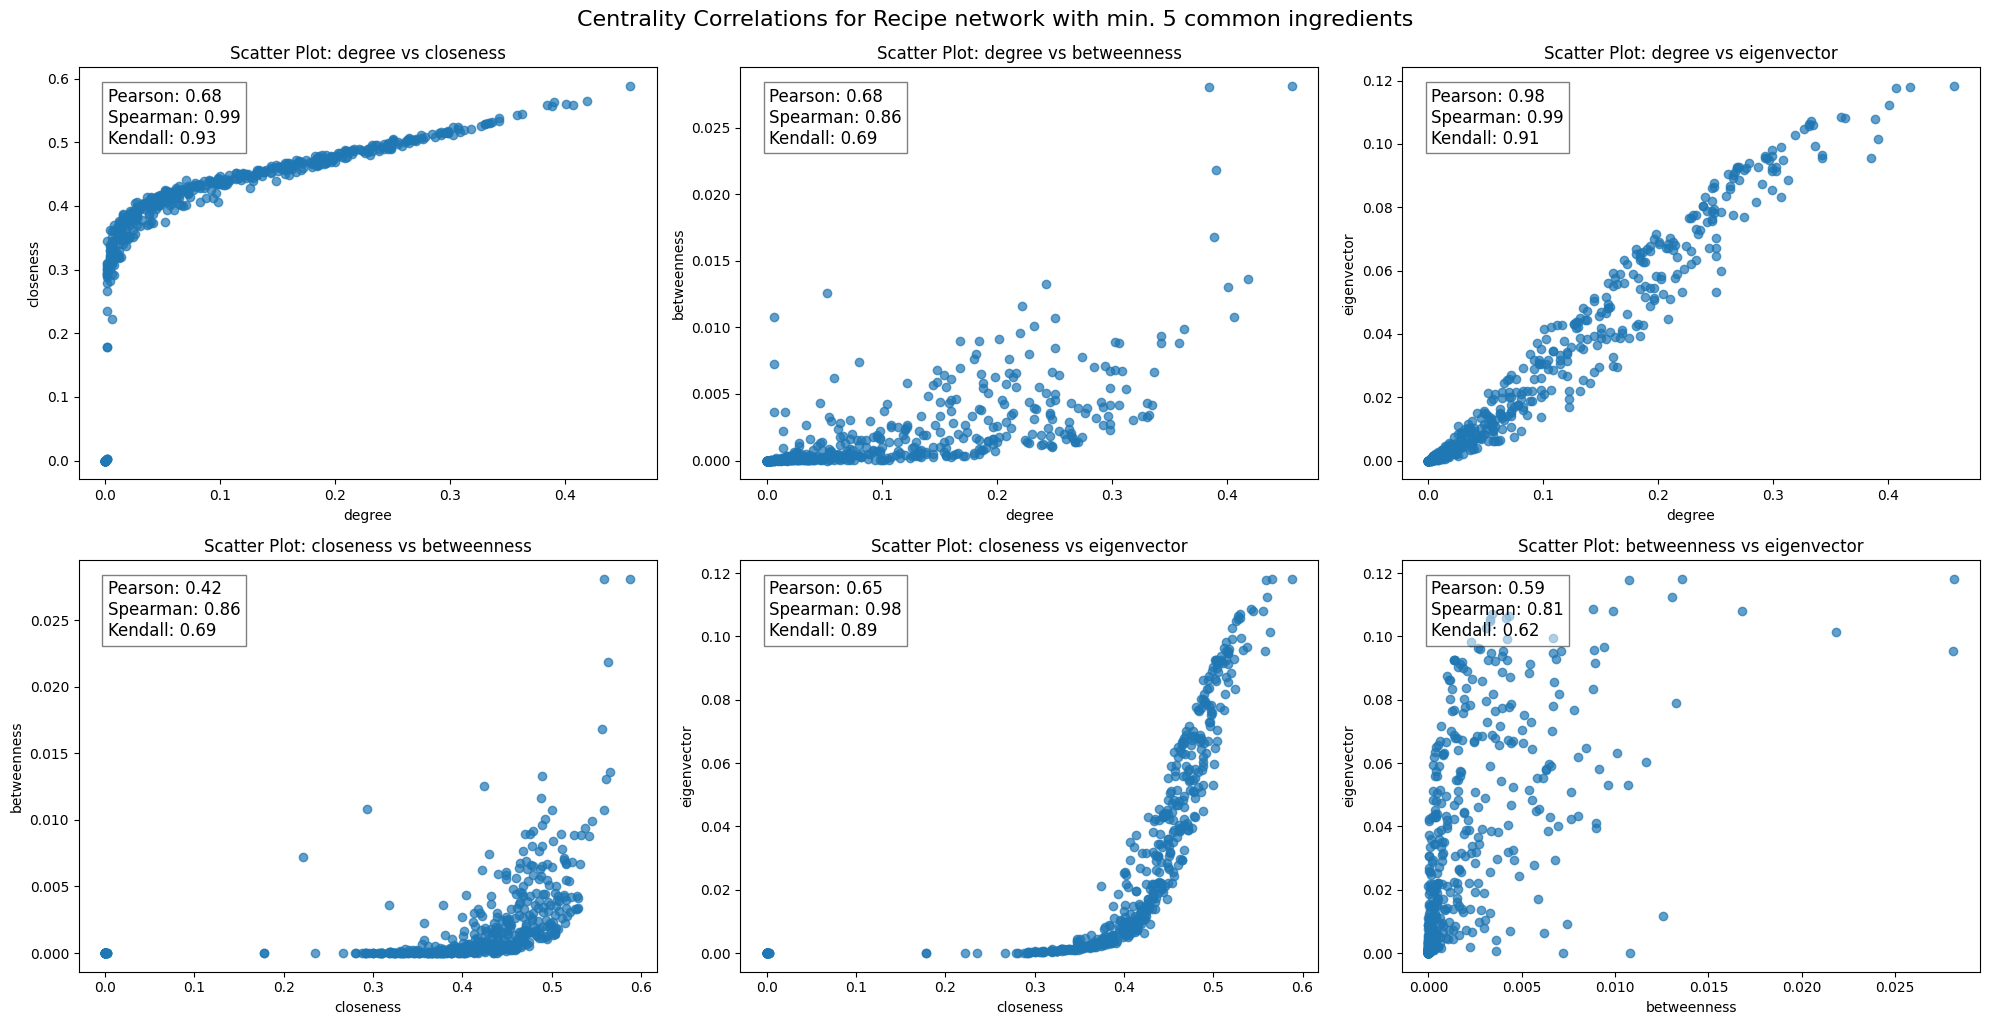

In [29]:
centralities = compute_centralities(recipes_2)
df = pd.DataFrame(centralities)
plot_centrality_scatter_plots(df, "Recipe network with min. 5 common ingredients")

In [30]:
from scipy.stats import pearsonr



def compute_pearson(df1, df2, col):
    return pearsonr(df1[col], df2[col])[0]

# This function plots the scatter plots for each centrality type, comparing the original and randomized graphs.
def plot_centrality_comparisons(df_original, df_randomized, graph_name):
    centrality_types = ['degree', 'closeness', 'betweenness', 'eigenvector']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, centrality in enumerate(centrality_types):
        pearson_corr = compute_pearson(df_original, df_randomized, centrality)
        
        # Scatter plot for original vs randomized
        axes[i].scatter(df_original[centrality], df_randomized[centrality], alpha=0.7, label=f'Pearson: {pearson_corr:.2f}')
        axes[i].set_title(f'Original vs Randomized: {centrality.capitalize()}', fontsize=14)
        axes[i].set_xlabel(f'Original {centrality.capitalize()}', fontsize=12)
        axes[i].set_ylabel(f'Randomized {centrality.capitalize()}', fontsize=12)
        axes[i].legend()
    
    plt.tight_layout()
    plt.suptitle(f'Centrality Comparisons: Original vs Randomized ({graph_name})', fontsize=16, y=1.02)
    plt.show()


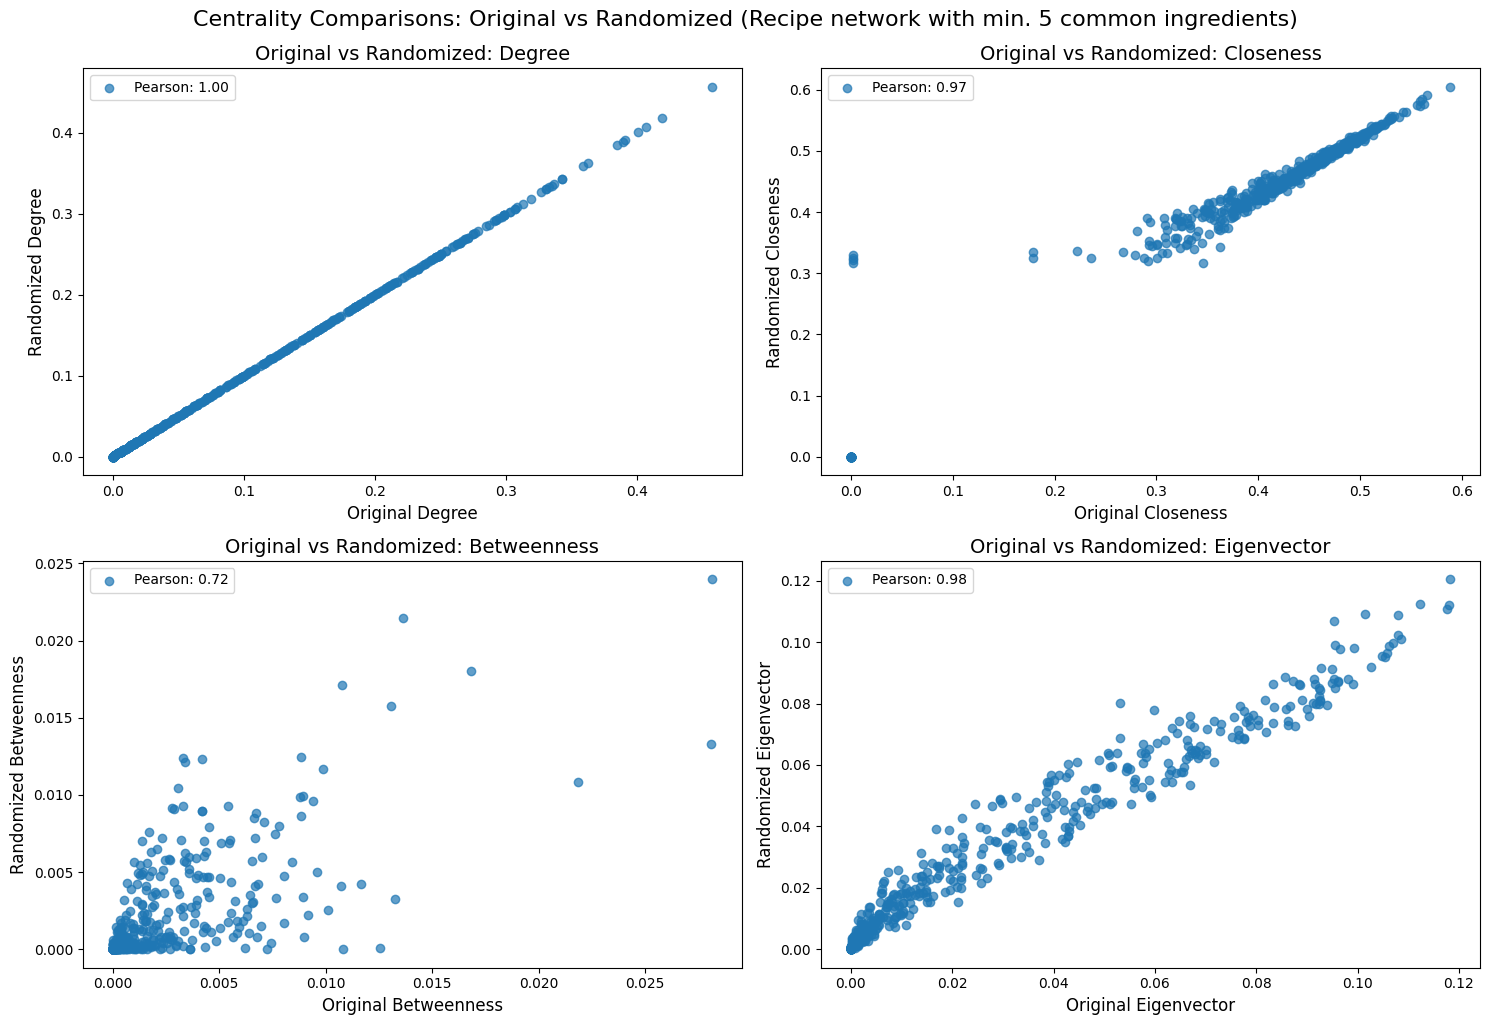

In [31]:
centralities = compute_centralities(recipes_2)
df = pd.DataFrame(centralities)
    
randomized_graph = randomize_graph(recipes_2)
randomized_centralities = compute_centralities(randomized_graph)
df_randomized = pd.DataFrame(randomized_centralities)
    
plot_centrality_comparisons(df, df_randomized, "Recipe network with min. 5 common ingredients")

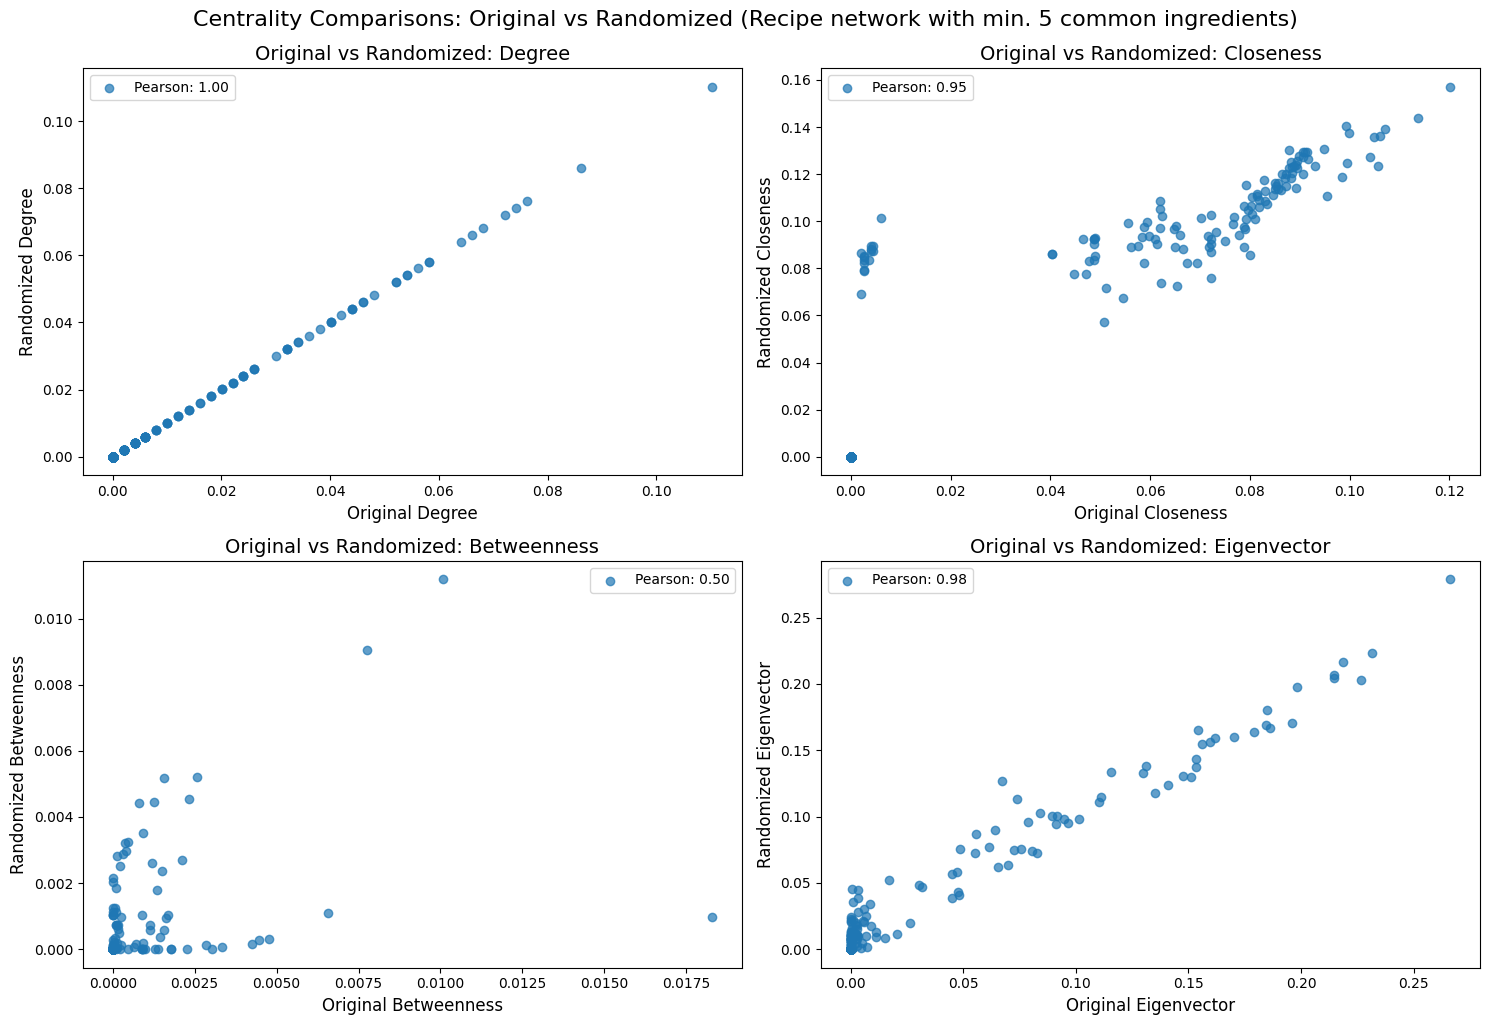

In [32]:
centralities = compute_centralities(recipes_5)
df = pd.DataFrame(centralities)
    
randomized_graph = randomize_graph(recipes_5)
randomized_centralities = compute_centralities(randomized_graph)
df_randomized = pd.DataFrame(randomized_centralities)
    
plot_centrality_comparisons(df, df_randomized, "Recipe network with min. 5 common ingredients")

### Observations

We can see on the plots that the Degree Centrality remains unchanged in the randomized graphs, because the degree distribution is preserved by the randomization. In case of Closeness and Betweenness Centrality we can see a lower correlation because randomization disrupts the shortest-path and flow structures. The Eigenvector Centrality also shows lower correlations but the difference is smaller, depending on how connected the nodes are in the random graph versus the original.

  
#### 1. Degree Centrality
Degree centrality measures the number of direct connections a node has within the network. A recipe with high degree centrality is one that shares a significant number of ingredients with many other recipes. These recipes likely use common ingredients and might represent versatile or foundational recipes that connect to many others.

During the randomization the edges are randomly rewired, but the node degrees remain unchanged, so the degree distribution remains the same, and therefore, the Degree Centrality remains unchanged, as the total number of connections for each node remained constant. Thats why it has 1.0 correlation.

#### 2. Closeness Centrality
Closeness centrality reflects how quickly a node can access other nodes in the network, measured by the average shortest path from that node to all others. A recipe with high closeness centrality can quickly "reach" or is closely connected to other recipes in the network. These recipes might be versatile in the sense that they use a set of ingredients that frequently appear in other recipes, making them central to the graph.

Closeness Centrality shows lower correlation because overall the shortest paths are disrupted because of the randomization.

#### 3. Betweenness Centrality
Betweenness centrality measures the extent to which a node serves as a bridge along the shortest paths between other nodes. Nodes with high betweenness centrality are critical for information flow or connectivity, acting as intermediaries. A recipe with high betweenness centrality acts as a "bridge" between clusters of recipes. These recipes likely share ingredients with multiple distinct groups of recipes and could play a crucial role in connecting different cuisines or cooking styles.

The Betweenness Centrality is also affected by the randomization because when the network is randomized shortest paths are removed or altered, and the nodes that served as intermediaries may no longer fulfill this role. This highlights the sensitivity of betweenness centrality to network structure. 

#### 4. Eigenvector Centrality
Eigenvector centrality evaluates a node's influence based not just on the number of connections but also on the quality and influence of its neighbors. A node connected to other well-connected nodes scores higher. A recipe with high eigenvector centrality is connected to other influential recipes. These recipes are central to the overall structure of the graph and might represent dishes with ingredients that are foundational to many popular or versatile recipes.

With the Eigenvector Centrality the correlation is affected less by the randomization,because it depends on how well the randomization maintains the overall connectivity and flow of importance across nodes. While randomization may disrupt connections, eigenvector centrality continues to reflect the influence of nodes based on their connections to other significant nodes.

#### Observed Differences and Similarities

Degree centrality remained stable in all cases, while closeness, betweenness, and eigenvector centralities were significantly affected by randomization, showcasing how the specific structure of the network influences the sensitivity of different centrality measures.


In [33]:
import powerlaw

from scipy.special import factorial
from scipy.stats import poisson, expon

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
import powerlaw

def plot_fit(G):
    degrees = [degree for _, degree in G.degree()]

    # Remove zero degrees to avoid issues with log scaling
    degrees = [d for d in degrees if d > 0]

    if len(degrees) == 0:
        print("No degrees greater than zero in the graph.")
        return

    fit = powerlaw.Fit(degrees, discrete=True)
    alpha = fit.alpha
    xmin = fit.xmin

    alpha_error = fit.sigma

    print(f"Alpha Error: {alpha_error}")
    print(f"Fitted alpha: {alpha}")

    lam = np.mean(degrees)

    # Safeguard against empty degrees
    hist, bin_edges = np.histogram(
        degrees,
        bins=np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), num=40),
        density=True
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    if np.any(np.isnan(hist)):
        print("Histogram contains NaN values. Check degree distribution.")
        return

    degree_values = np.arange(1, max(degrees) + 1)
    poisson_prob = (lam ** degree_values * np.exp(-lam)) / factorial(degree_values)
    exponential_prob = (1 / lam) * np.exp(-degree_values / lam)

    plt.figure(figsize=(7, 5))

    plt.loglog(bin_centers, hist, 'o', color='blue', markersize=5, label="Empirical Data")
    fit.power_law.plot_pdf(color='red', label=f"Power-Law Fit (α={alpha:.2f})")
    plt.loglog(degree_values, poisson_prob, 'g-', label=f'Poisson Fit (λ = {lam:.2f})')
    plt.loglog(degree_values, exponential_prob, 'm-', label=f'Exponential Fit (λ = {lam:.2f})')

    plt.xlabel("Degree (k)", fontsize=12)
    plt.ylabel("Probability (p(k))", fontsize=12)
    plt.title("Empirical Degree Distribution with Power-Law, Poisson, and Exponential Fits", fontsize=14)
    plt.legend()

    max_empirical_prob = np.nanmax(hist)  # Use nan-safe max function
    if max_empirical_prob > 0:
        plt.ylim(1e-6, max_empirical_prob * 1.1)
    else:
        print("Maximum empirical probability is zero or invalid.")
        return

    plt.show()


Calculating best minimal value for power law fit
Alpha Error: 0.569872420330063
Fitted alpha: 5.9022279203960375


C:\Users\Ákos\AppData\Local\Temp\ipykernel_3524\347661397.py:40: RuntimeWarning: overflow encountered in power
  poisson_prob = (lam ** degree_values * np.exp(-lam)) / factorial(degree_values)
C:\Users\Ákos\AppData\Local\Temp\ipykernel_3524\347661397.py:40: RuntimeWarning: invalid value encountered in divide
  poisson_prob = (lam ** degree_values * np.exp(-lam)) / factorial(degree_values)


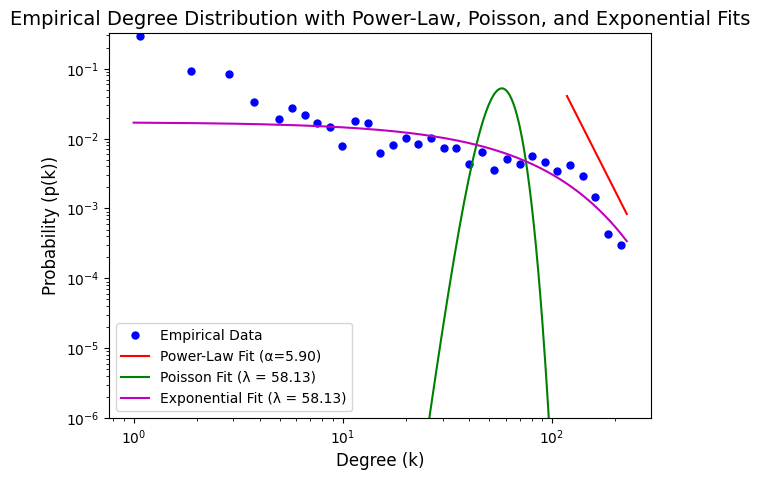

In [35]:
plot_fit(recipes_2)

Calculating best minimal value for power law fit
Alpha Error: 1.8992165573021944
Fitted alpha: 6.371795626440604


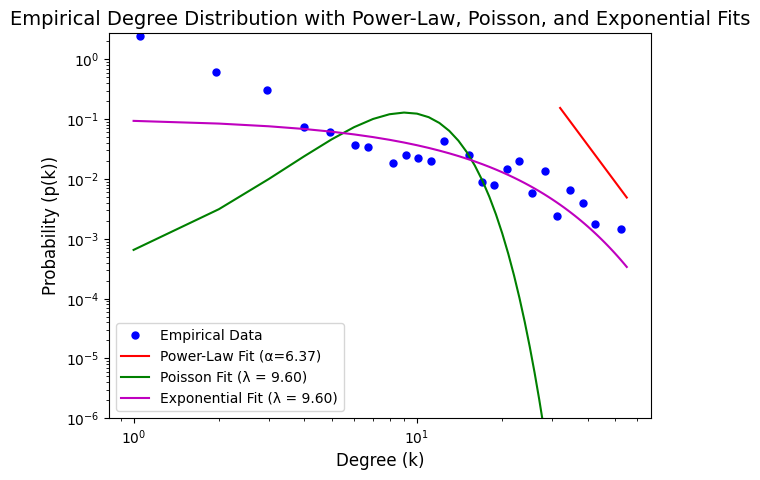

In [36]:
plot_fit(recipes_5)